## Deep neural network for image classification with pytorch

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.optim import SGD
from torch.utils.data import Dataset, DataLoader
from src.utils import *

In [2]:
# import the data
train_x_orig, train_y, test_x_orig, test_y, classes = load_data('./data/train_catvnoncat.h5','./data/test_catvnoncat.h5')

In [3]:
type(train_y)

numpy.ndarray

In [4]:
#Change y dtype and transpose.
train_y = train_y.astype('float32')
test_y = test_y.astype('float32')
train_y = train_y.T
test_y = test_y.T

# Explore the dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]


print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (209, 1)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (50, 1)


In [5]:
# load the data into pytorch dataset object
class Data(Dataset):

    transform = T.Compose([
        T.ToPILImage(),
        T.Resize([64,64]),
        T.ToTensor()])

    def __init__(self,x,y):
        self.x = x
        self.y = y
        self.len = y.shape[0]

    #Getter
    def __getitem__(self,index):
        img = self.x[index]
        x = self.transform(img)
        return x, self.y[index]
    
    #Getlength
    def __len__(self):
        return self.len
    
    #plot example
    def plot(self,index):
        x_,y_ = self.__getitem__(index)
        print('y=',y_)
        to_pil = T.ToPILImage()
        img = to_pil(x_)
        img.show()

train_data = Data(train_x_orig,train_y)
test_data = Data(test_x_orig,test_y)

y= [0.]


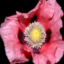

In [6]:
#plot example
train_data.plot(140)

y= [0.]


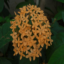

In [7]:
test_data.plot(43)

### Train a 4 layer fully connected nerual network with pytorch

In [38]:
# Create Net model class, activation=relu, softmax for the last layer

class Net(nn.Module):
    
    # Constructor
    def __init__(self, Layers):
        super(Net, self).__init__()
        self.hidden = nn.ModuleList()
        for input_size, output_size in zip(Layers, Layers[1:]):
            self.hidden.append(nn.Linear(input_size, output_size))
    
    # Prediction
    def forward(self, activation):
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                activation = F.relu(linear_transform(activation))
            else:
                activation = torch.sigmoid(linear_transform(activation))
        return activation

# create the net
layers = [64*64*3,20,7,5,1]
model = Net(layers)


In [39]:
# Create the criterion function, here we use CrossEntropyLoss
criterion = nn.BCELoss()

# create train loader and test loader for BGD
train_loader = DataLoader(train_data,batch_size=20,shuffle=True)
test_loader = DataLoader(test_data,batch_size=10)

#set optimizer
learning_rate = 0.01
optimizer = SGD(model.parameters(),lr=learning_rate)

In [40]:
# Define the function for training the model

def train(model, criterion, train_loader, optimizer, epochs=800):
    LOSS = [] #train loss
    for i in range(epochs):
        for x, y in train_loader:
            yhat = model(x.view(-1,64*64*3))
            loss = criterion(yhat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            LOSS.append(loss.data.item())
        if i%100==0 or i==epochs-1:
            print(f"cost after {i} epochs is {loss.data.item()}")
    return LOSS

def predict(model,test_loader):
    correct=0
    for x,y in test_loader:
        y_ = model(x.view(-1,64*64*3))
        label = (y_>0.5).long()
        correct += torch.sum(y==label).item()
    accuracy = correct/len(test_y)
    return(accuracy)
    

In [41]:
#train the model
train_loss = train(model,criterion,train_loader,optimizer,epochs=1000)

cost after 0 epochs is 0.6870478987693787
cost after 100 epochs is 0.2714141607284546
cost after 200 epochs is 0.005794072523713112
cost after 300 epochs is 0.0009553296840749681
cost after 400 epochs is 0.001604348188266158
cost after 500 epochs is 7.603657286381349e-05
cost after 600 epochs is 0.00015844297013245523
cost after 700 epochs is 4.0990351408254355e-05
cost after 800 epochs is 0.0003804539155680686
cost after 900 epochs is 0.0001861724886111915
cost after 999 epochs is 9.148631215794012e-05


Text(0, 0.5, 'cost')

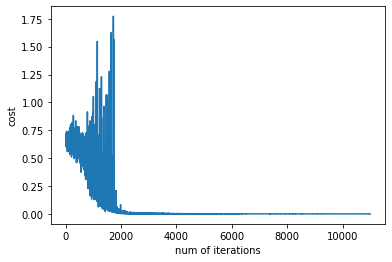

In [42]:
# plot the change in loss
plt.plot(train_loss)
plt.xlabel('num of iterations')
plt.ylabel('cost')

In [43]:
#run the model on the test set and calculate accuracy
predict(model,test_loader)

0.72